In [1]:
%matplotlib inline

# Graph Structures
## Theano Graph
- 왜 갑자기 graph? 
- Theano로 만든 code를 debuggin 하거나 profiling 하는 건 쉽지 않다.
- 블랙박스 속에서 무슨 일이 벌어지고 있는 지 모른다면
- 이해하기 위해 필요한 만큼만 들여다 보자. 자세한 건 Extending Theano를 보고...

- Theano code를 쓰는 첫번째 단계는 관련된 모든 수학적 관계식을 symbolic placeholder (variable)를 이용하여 기술하는 것이다.
- 이러한 expression에는 사칙연산, 삼각함수 등 여러가지가 있다.
- 이러한 모든 expression은 내부적으로는 *ops* 로 나타내어진다.
- op.라는 것은 특정한 input을 받아 연산하고 정해진 type의 output을 내는 것을 의미한다.
- 대부분의 프로그래밍 언어에서 이야기하는 function definitions으로 생각해도 되겠다.
- Theano는 내부적으로 _variable node_, _op node_, _apply node_ 가 연결된 graph structure를 만든다.
- apply node는 vaiable에 뭔가를 하는 op을 나타낸다고 생각하자.
- op에 의해 나타내어지는 연산의 정의와 특정한 data type에 적용하는 것 그래서 apply node로 나타나는 것 사이의 차이를 그려보는 것은 중요한 일이다.
- 우선 아래 graph의 예를 보자.

In [2]:
from theano import *
import theano.tensor as T
from theano import function

Using gpu device 0: GeForce GTX 980 Ti


In [3]:
x = T.dscalar('x')
y = T.dscalar('y')
z = x + y
f = function([x, y], z)

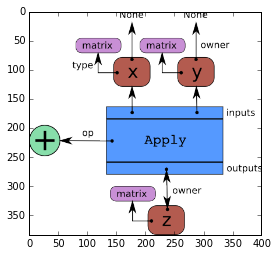

In [4]:
import matplotlib.pyplot as plt
import Image
im = Image.open('apply1.png')
plt.imshow(im)

- 위 그림에서 화살표는 Python 객체에 대한 참조를 나타내고 있다.
- 청색 상자는 _Apply node_이고 (Computation graph를 표시하기 위해 쓰는 내부 노드 (_Variable node_ 와는 달리 사용자가 직접 조작하지 않는다.)
- 붉은색 상자는 _Variable node_ 이다. 
- 초록색 원은 _Ops_ 이고 보라색 상자는 _Type_이라고 한다.
- 주) 그런데 z = x + y 에 대한 정보는 없다?
- 이 그래프는 output (여기서는 어떤 연산)에서 시작하여 input 까지 따라가며 조사할 수 있는데 owner filed를 이용하여 가능하다고 한다.
- 아래 코드를 보자.

In [5]:
import theano
x = theano.tensor.dmatrix('x')
y = x * 2.

- `type(y.owner)` 하면 `<class 'theano.gof.graph.Apply'>` 의 결과를 얻을 수 있는데, 이것은 Apply node와 input을 이어주는 것이라 한다.

In [6]:
type(y.owner)

theano.gof.graph.Apply

- 이제 y를 얻기 위해 적용되는 op 의 이름을 출력해보자.

In [7]:
y.owner.op.name

'Elemwise{mul,no_inplace}'

- 위의 출력값으로 y 를 계산하기 위해서 elementwise multiplication 이 사용된다는 것을 알았다.
- 이 연산(op)는 어떤 input 에 대해 적용되고 있는지 알아보자.

In [8]:
len(y.owner.inputs)

2

- 두 개의 input 을 받아 연산(op)하는 것이며

In [9]:
y.owner.inputs[0]

x

- 그 중 첫번째 것은 x 이고

In [10]:
y.owner.inputs[1]

DimShuffle{x,x}.0

- 두 번째 것은 예상과는 달리 2가 나오지 않았다.
- 이것은 우선 2가 x와 동일한 모양의 matrix로 broadcast 되기 때문인데
    - broadcast: 차원(dimension)이 다른 텐서가 elementwise computations 될 수 있도록 해주는 것이라 한다.
    - 이것은 차원이 낮은 텐서를 차원이 높은 텐서로 가상적으로 복제함으로써 이루어진다.
    - 자세한 것은 Broadcasting in Theano vs. Numpy 를 보고
    - SciPy documentation about numpy's broadcasting 도 
    - OnLamp article about numpy’s broadcasting 도 보면 좋겠다.
- 이것은 `DimShuffle` 이라는 op를 통해 이루어진다.

그래서 각각의 type을 한번 알아보면

In [11]:
type(y.owner.inputs[1])

theano.tensor.var.TensorVariable

- 이미 텐서이고...

In [12]:
type(y.owner.inputs[1].owner)

theano.gof.graph.Apply

In [13]:
y.owner.inputs[1].owner.op

- 이렇게 바꾸어준 범인은 DimShuffle 임!

In [14]:
y.owner.inputs[1].owner.inputs

[TensorConstant{2.0}]

- Dimshuffle 이 받은 원래의 input 값은 텐서 상수 2.0 임을 알 수 있다.

## Automatic Differentiation
- 이 그래프 구조를 안다면 자동화된 미분(automatics differentiation)은 쉽다고 한다.
- chain rule 에 따라 진행 가능.
- `tensor.grad()` 가 하는 일은 output에서부터 input까지 그래프를 역탐색하는데, 모든 apply node를 둘러보아야 하는 것이다.
    - (apply node는 어떤 연산(computation)을 할지 정의해두고 있는 node이다.)
- 각 apply node에 대해, op는 gradient의 ...

- 자세한 내용은 differentiation 에 있으니 읽어 보세요.

In [22]:
from theano import pp
x = T.dscalar('x')
y = x ** 2
gy = T.grad(y, x)
pp(gy)  # print out the gradient prior to optimization
# '((fill((x ** 2), 1.0) * 2) * (x ** (2 - 1)))'

'((fill((x ** TensorConstant{2}), TensorConstant{1.0}) * TensorConstant{2}) * (x ** (TensorConstant{2} - TensorConstant{1})))'

In [23]:
f = function([x], gy)
f(4)
# array(8.0)

array(8.0)

In [24]:
f(94.2)
# array(188.40000000000001)

array(188.4)

## Optimizations
- Theano function을 컴파일 할 때, theano.function에 넘겨주는 것은 확실히 그래프이다.
- 이 그래프 구조는 input 으로부터 output을 어떻게 계산할지를 보여주고 있는데,
- 이와 더불어 계산방법에 대한 개선을 할 여지가 있는지도 볼 수 있다.
- Theano 에서의 이 계산 과정 최적화는 그래프에서 특정한 패턴을 찾고 대치하는 식으로 이루어지는데
- 이렇게 대치된 것은 동일한 결과를 주지만 더 빠르고 안정적이라고 한다.
- 최적화에는 또한 동일한 서브그래프를 찾고 동일한 결과를 다시 계산하지 않도록 하거나,
- GPU 에 최적화된 연산으로 식을 바꾸는 것도 포함된다.
- 예를 들어 xy / y 를 x 로 대치하는 식이다.
- 여기도 한번 읽어보세요.
    - the optimization process and the specific optimizations that are applicable

### Example

In [15]:
import theano
a = theano.tensor.vector("a")      # declare symbolic variable
b = a + a ** 10                    # build symbolic expression
f = theano.function([a], b)        # compile function
print f([0, 1, 2])                 # prints `array([0,2,1026])`

[    0.     2.  1026.]


In [16]:
theano.printing.pydotprint(b, outfile="./symbolic_graph_unopt.png", var_with_name_simple=True)

The output file is available at ./symbolic_graph_unopt.png


In [17]:
theano.printing.pydotprint(f, outfile="./symbolic_graph_opt.png", var_with_name_simple=True)

The output file is available at ./symbolic_graph_opt.png


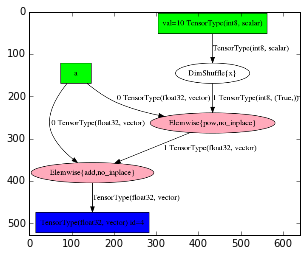

In [18]:
im = Image.open('symbolic_graph_unopt.png')
plt.imshow(im)

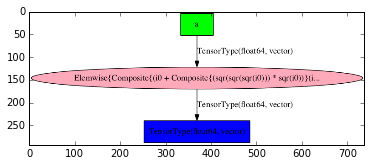

In [21]:
im = Image.open('symbolic_graph_opt.png')
plt.imshow(im)

# Printing / Drawing Theano graphs

In [25]:
>>> import numpy
>>> import theano
>>> import theano.tensor as T
>>> rng = numpy.random
>>> # Training data
>>> N = 400
>>> feats = 784
>>> D = (rng.randn(N, feats).astype(theano.config.floatX), rng.randint(size=N,low=0, high=2).astype(theano.config.floatX))
>>> training_steps = 10000
>>> # Declare Theano symbolic variables
>>> x = T.matrix("x")
>>> y = T.vector("y")
>>> w = theano.shared(rng.randn(feats).astype(theano.config.floatX), name="w")
>>> b = theano.shared(numpy.asarray(0., dtype=theano.config.floatX), name="b")
>>> x.tag.test_value = D[0]
>>> y.tag.test_value = D[1]
>>> # Construct Theano expression graph
>>> p_1 = 1 / (1 + T.exp(-T.dot(x, w)-b)) # Probability of having a one
>>> prediction = p_1 > 0.5 # The prediction that is done: 0 or 1
>>> # Compute gradients
>>> xent = -y*T.log(p_1) - (1-y)*T.log(1-p_1) # Cross-entropy
>>> cost = xent.mean() + 0.01*(w**2).sum() # The cost to optimize
>>> gw,gb = T.grad(cost, [w,b])
>>> # Training and prediction function
>>> train = theano.function(inputs=[x,y], outputs=[prediction, xent], updates=[[w, w-0.01*gw], [b, b-0.01*gb]], name = "train")
>>> predict = theano.function(inputs=[x], outputs=prediction, name = "predict")

## Pretty Printing

In [26]:
>>> theano.printing.pprint(prediction) 

'gt((TensorConstant{1} / (TensorConstant{1} + exp(((-(x \\dot HostFromGpu(w))) - HostFromGpu(b))))), TensorConstant{0.5})'

## Debug Print
The pre-compilation graph:

In [27]:
>>> theano.printing.debugprint(prediction) 

Elemwise{gt,no_inplace} [@A] ''   
 |Elemwise{true_div,no_inplace} [@B] ''   
 | |DimShuffle{x} [@C] ''   
 | | |TensorConstant{1} [@D]
 | |Elemwise{add,no_inplace} [@E] ''   
 |   |DimShuffle{x} [@F] ''   
 |   | |TensorConstant{1} [@D]
 |   |Elemwise{exp,no_inplace} [@G] ''   
 |     |Elemwise{sub,no_inplace} [@H] ''   
 |       |Elemwise{neg,no_inplace} [@I] ''   
 |       | |dot [@J] ''   
 |       |   |x [@K]
 |       |   |HostFromGpu [@L] ''   
 |       |     |w [@M]
 |       |DimShuffle{x} [@N] ''   
 |         |HostFromGpu [@O] ''   
 |           |b [@P]
 |DimShuffle{x} [@Q] ''   
   |TensorConstant{0.5} [@R]


In [ ]:
The post-compilation graph:

In [28]:
>>> theano.printing.debugprint(predict) 

Elemwise{gt,no_inplace} [@A] ''   7
 |HostFromGpu [@B] ''   6
 | |GpuElemwise{Composite{scalar_sigmoid((-((-i0) - i1)))}}[(0, 0)] [@C] ''   5
 |   |GpuGemv{inplace} [@D] ''   4
 |   | |GpuAlloc{memset_0=True} [@E] ''   3
 |   | | |CudaNdarrayConstant{0.0} [@F]
 |   | | |Shape_i{0} [@G] ''   2
 |   | |   |x [@H]
 |   | |TensorConstant{1.0} [@I]
 |   | |GpuFromHost [@J] ''   1
 |   | | |x [@H]
 |   | |w [@K]
 |   | |TensorConstant{0.0} [@L]
 |   |GpuDimShuffle{x} [@M] ''   0
 |     |b [@N]
 |TensorConstant{(1,) of 0.5} [@O]


## Picture Printing of Graphs
The pre-compilation graph:

In [31]:
>>> theano.printing.pydotprint(prediction, outfile="logreg_pydotprint_prediction.png", var_with_name_simple=True)
# The output file is available at pics/logreg_pydotprint_prediction.png

The output file is available at logreg_pydotprint_prediction.png


<img src="logreg_pydotprint_prediction.png"/>
The post-compilation graph:

In [32]:
>>> theano.printing.pydotprint(predict, outfile="logreg_pydotprint_predict.png", var_with_name_simple=True)

The output file is available at logreg_pydotprint_predict.png


<img src="logreg_pydotprint_predict.png"/>
The optimized training graph:

In [33]:
>>> theano.printing.pydotprint(train, outfile="logreg_pydotprint_train.png", var_with_name_simple=True)

The output file is available at logreg_pydotprint_train.png


<img src="logreg_pydotprint_train.png"/>